https://discourse.pymc.io/t/sampling-uniformly-in-a-triangular-support/765/

In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
import pystan

%pylab inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
with pm.Model() as m:
    x = pm.Uniform('x', 0., 1., shape=2)
    pm.Potential('ordered', tt.switch(x[1]-x[0] < 0, -np.inf, 0))
    tr = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_interval__]
INFO:pymc3:NUTS: [x_interval__]
  0%|          | 0/1000 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '29956' (I am process '29957')
INFO (theano.gof.compilelock): Waiting for existing lock by process '29956' (I am process '29958')
INFO:theano.gof.compilelock:Waiting for existing lock by process '29956' (I am process '29958')
INFO:theano.gof.compilelock:Waiting for existing lock by process '29956' (I am process '29957')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/laoj/.theano/co

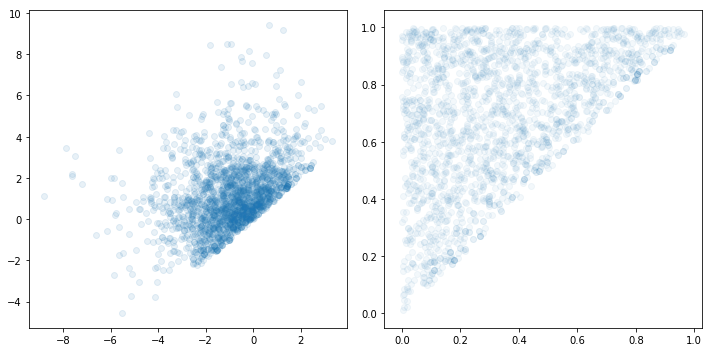

In [3]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr['x_interval__'][:, 0], tr['x_interval__'][:, 1], alpha=.1)
ax[1].scatter(tr['x'][:, 0], tr['x'][:, 1], alpha=.05)
plt.tight_layout();

In [4]:
def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

def normcdf1(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.cos(angle) * thetap1) - (np.sin(angle) * tt.abs_(thetap2)))

def normcdf2(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.sin(angle) * thetap1) + (np.cos(angle) * tt.abs_(thetap2)))

with pm.Model() as m1:
    thetap = pm.MvNormal('thetap', mu=0., cov=np.eye(2), shape=2)
    
    x1 = pm.Deterministic('x1', normcdf1(thetap[0], thetap[1]))
    x2 = pm.Deterministic('x2', normcdf2(thetap[0], thetap[1]))

    tr1 = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetap]
INFO:pymc3:NUTS: [thetap]
100%|██████████| 1000/1000 [00:01<00:00, 584.94it/s]


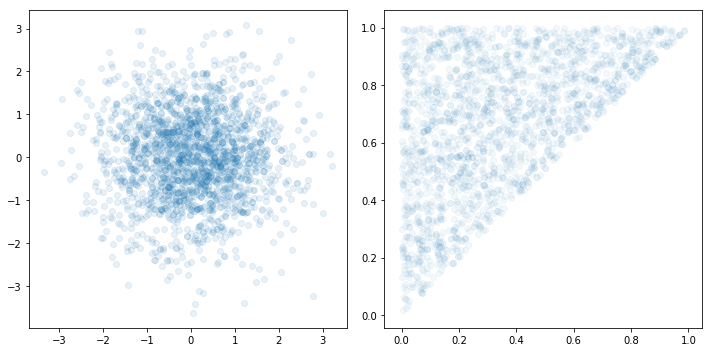

In [5]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr1['thetap'][:, 0], tr1['thetap'][:, 1], alpha=.1)
ax[1].scatter(tr1['x1'], tr1['x2'], alpha=.05)
plt.tight_layout();

In [6]:
datadict = {}
datadict['N'] = 2
stan_m = """
    data {
        int<lower=1> N;
    }
    parameters {
        ordered[N] x;
    }
    model {
        x ~ uniform(0, 1);
        // target += uniform_lpdf(x | 0, 1);
    }
    """

tr_stan = pystan.stan(model_code=stan_m, data=datadict,
                      iter=5000, warmup=1000, 
                      chains=4, n_jobs=4, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a354c77b7a6aa37371be175bb3cd19cd NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1816:0,
                 from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmp8bk2gfmo/stanfit4anon_model_a354c77b7a6aa37371be175bb3cd19cd_5602761345480878020.cpp:599:
/usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /usr/local/lib/python3.5/dist-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0/boost/multi_array/base.hpp:28:0,
                 from /usr/local/lib/python3.5/d

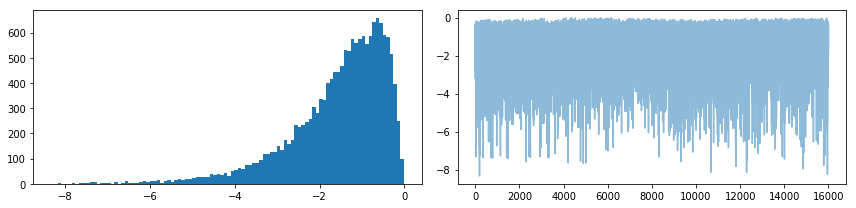

In [7]:
tr_x = tr_stan.extract()['x']
lnp = tr_stan.extract()['lp__']

_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

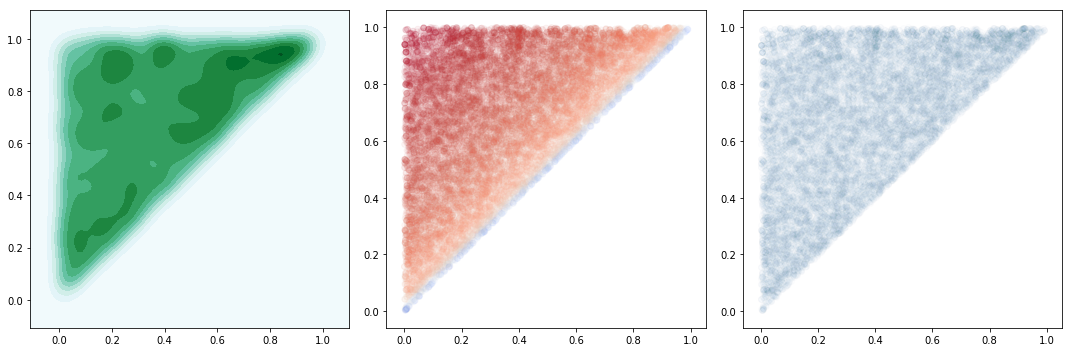

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(tr_x[:, 0], tr_x[:, 1], shade=True, ax=ax[0])
ax[1].scatter(tr_x[:, 0], tr_x[:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(tr_x[:, 0], tr_x[:, 1], alpha=.01)
plt.tight_layout();

In [9]:
x = np.random.rand(1, 5).squeeze()
x

array([0.86307358, 0.74423682, 0.34977916, 0.09924745, 0.54345436])

In [10]:
def backward1(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        if i>0:
            y[i] = y[i-1] + np.exp(x[i])
    return y

y = backward1(x)
y

array([0.86307358, 2.96790804, 4.38666224, 5.49100178, 7.2129466 ])

In [11]:
def backward2(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    y[1:] = np.exp(x[1:])
    return np.cumsum(y)

y = backward2(x)
y

array([0.86307358, 2.96790804, 4.38666224, 5.49100178, 7.2129466 ])

In [12]:
def forward2(y):
    x = np.zeros_like(y)
    x[0] = y[0]
    x[1:] = np.log(y[1:] - y[:-1])
    return x

x2 = forward2(y)
x2

array([0.86307358, 0.74423682, 0.34977916, 0.09924745, 0.54345436])

In [13]:
class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0])
        x = tt.inc_subtensor(x[1:], tt.log(y[1:] - y[:-1]))
        return x

    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0])
        y = tt.inc_subtensor(y[1:], tt.exp(x[1:]))
        return tt.cumsum(y)
    
    def jacobian_det(self, y):
        return tt.sum(y[1:])

class Composed(pm.distributions.transforms.Transform):
    def __init__(self, trafo1, trafo2):
        self._trafo1 = trafo1
        self._trafo2 = trafo2
        self.name = '_'.join([trafo1.name, trafo2.name])

    def forward(self, x):
        return self._trafo2.forward(self._trafo1.forward(x))

    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._trafo1.backward(self._trafo2.backward(y))

    def jacobian_det(self, y):
        y2 = self._trafo2.backward(y)
        det1 = self._trafo1.jacobian_det(y2)
        det2 = self._trafo2.jacobian_det(y)
        return det1 + det2


with pm.Model() as m2:
    chain_tran = Composed(pm.distributions.transforms.Interval(0., 1.), Ordered())
    x = pm.Uniform('x', 0., 1., shape=2,
                   transform=chain_tran,
                   testval=[0.1, 0.9])
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(5000, tune=5000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_interval_ordered__]
INFO:pymc3:NUTS: [x_interval_ordered__]
100%|██████████| 10000/10000 [00:12<00:00, 790.97it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6678125169760389, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [14]:
varnames = tr2.varnames
varnames

['x_interval_ordered__', 'x', 'jacobian']

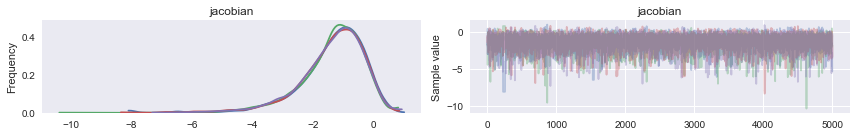

In [15]:
pm.traceplot(tr2, varnames=['jacobian']);

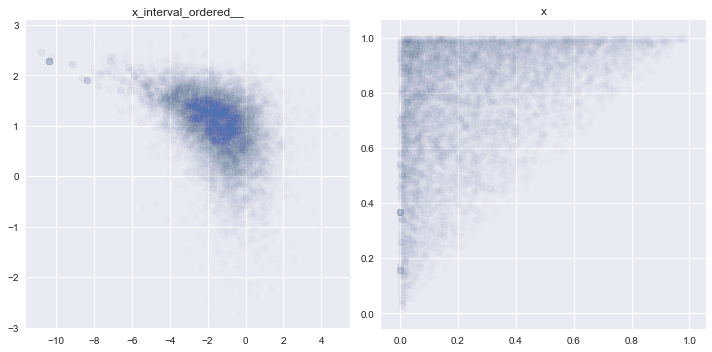

In [16]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(tr2[varname][:, 0], tr2[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [17]:
upper, lower = 0., 1.
class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0])
        x = tt.inc_subtensor(x[1:], tt.log(y[1:] - y[:-1]))
        return x

    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0])
        y = tt.inc_subtensor(y[1:], tt.exp(x[1:]))
        return tt.cumsum(y)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

with pm.Model() as mtest:
    x = pm.Flat('x_real', shape=2, testval=[2., 1.])
    Order = Ordered()
    pm.Potential('y1', Order.jacobian_det(x))
    
    x1 = Order.backward(x)
    Interval = pm.distributions.transforms.Interval(upper, lower)
    x2 = pm.Deterministic('x_interval_ordered', Interval.backward(x1))
    pm.Potential('y2', pm.Uniform.dist(upper, lower).logp(x2) + Interval.jacobian_det(x1))
    
    pm.Deterministic('jacobian', Order.jacobian_det(x) + Interval.jacobian_det(x1))
    
    trtest = pm.sample(5000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_real]
INFO:pymc3:NUTS: [x_real]
100%|██████████| 5500/5500 [00:07<00:00, 724.16it/s]


In [18]:
varnames = trtest.varnames
varnames

['x_real', 'x_interval_ordered', 'jacobian']

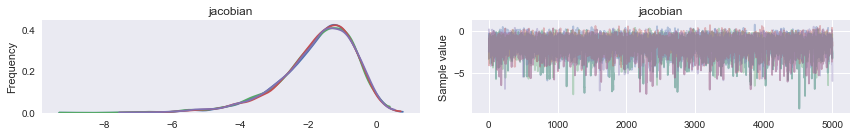

In [19]:
pm.traceplot(trtest, varnames=['jacobian']);

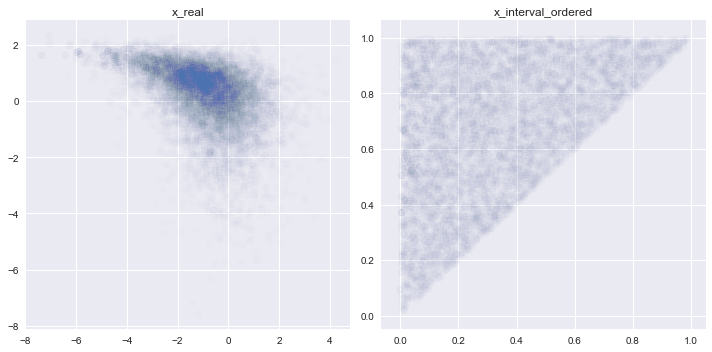

In [20]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(trtest[varname][:, 0], trtest[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [21]:
m2.test_point

{'x_interval_ordered__': array([-2.19722458,  1.48034219])}

In [22]:
mtest.test_point

{'x_real': array([2., 1.])}

In [23]:
m2.logp(m2.test_point)

array(-1.85520684)

In [24]:
point2 = dict(x_real=m2.test_point['x_interval_ordered__'])
point2

{'x_real': array([-2.19722458,  1.48034219])}

In [25]:
mtest.logp(point2)

array(-3.33554903)

In [26]:
chain_tran.backward(np.array([2., 1.])).eval()

array([0.88079708, 0.99114854])

In [27]:
x2.tag.test_value

array([0.88079708, 0.99114854])

In [28]:
inputval = x2.tag.test_value
# inputval = point2['x_real']

In [29]:
chain_tran.forward(inputval).eval()

array([2., 1.])

In [30]:
chain_tran.jacobian_det(inputval).eval()

array([-0.5831335 , -2.63922934])

In [31]:
y = inputval
y2 = chain_tran._trafo2.backward(y)
det1 = chain_tran._trafo1.jacobian_det(y2)
print(det1.eval())
det2 = chain_tran._trafo2.jacobian_det(y)
print(det2.eval())

[-1.57428204 -3.63037788]
0.9911485385394977


In [32]:
(Order.jacobian_det(inputval) + Interval.jacobian_det(Order.backward(inputval))).eval()

array([-0.5831335 , -2.63922934])

In [33]:
y2 = Order.backward(y)
det1 = Interval.jacobian_det(y2)
print(det1.eval())
det2 = Order.jacobian_det(y)
print(det2.eval())

[-1.57428204 -3.63037788]
0.9911485385394977


In [34]:
logp = m2.logp
lnp = np.array([logp(tr2.point(i,chain=c)) for c in tr2.chains for i in range(len(tr2))])

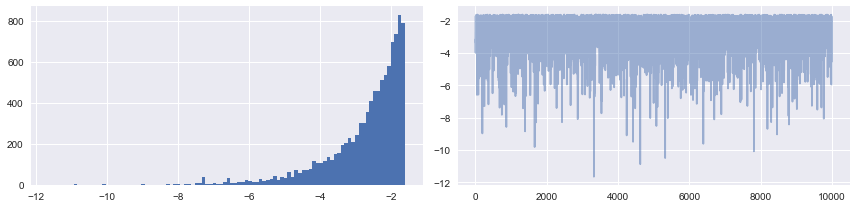

In [35]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

In [36]:
logp = mtest.logp
lnp = np.array([logp(trtest.point(i,chain=c)) for c in trtest.chains for i in range(len(trtest))])

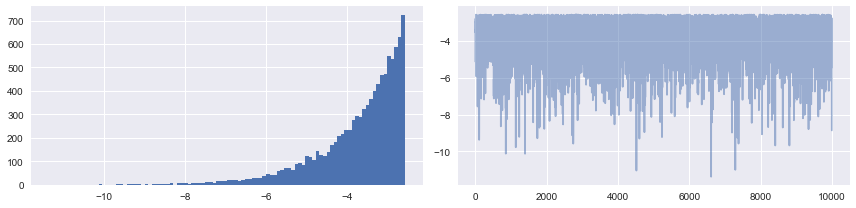

In [37]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

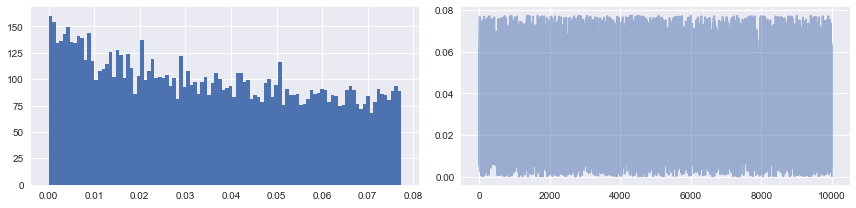

In [38]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(np.exp(lnp), 100)
ax[1].plot(np.exp(lnp), alpha=.5);
plt.tight_layout();

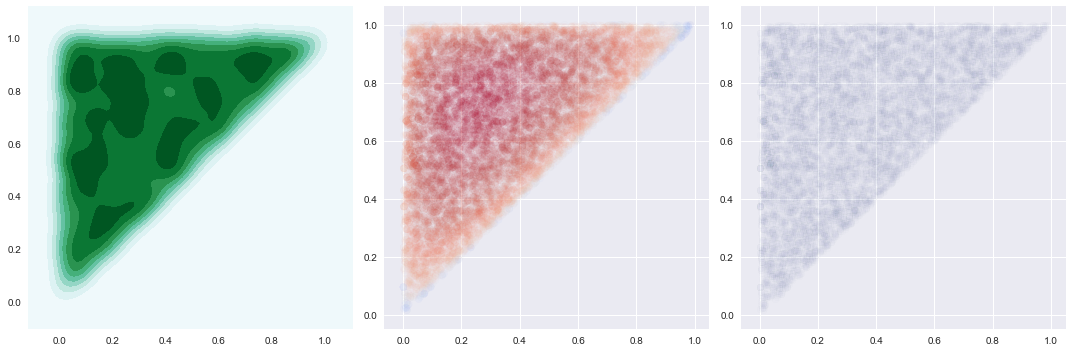

In [42]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

varname = 'x_interval_ordered'
sns.kdeplot(trtest[varname][:, 0], trtest[varname][:, 1], shade=True, ax=ax[0])
ax[1].scatter(trtest[varname][:, 0], trtest[varname][:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(trtest[varname][:, 0], trtest[varname][:, 1], cmap=plt.cm.coolwarm,
           alpha=.01)
plt.tight_layout();

https://discourse.pymc.io/t/order-statistics-in-pymc3/617/3

[4 2 0 1 3]
[[2 2 2 2 2 2 2 3 2 1 2 2 2 2 2 3 3 2 2 2 2 2 2 3 1 2 2 3 2 3]
 [3 3 1 3 3 1 3 2 1 0 3 1 1 4 1 2 2 3 3 3 3 1 3 1 2 3 1 2 3 2]
 [1 1 3 1 1 3 4 4 3 3 1 3 3 3 3 4 4 4 4 4 1 3 4 2 3 1 3 1 1 1]
 [4 4 4 0 0 0 0 1 0 2 4 0 4 0 4 1 1 1 1 1 4 4 0 4 4 4 0 0 0 4]
 [0 0 0 4 4 4 1 0 4 4 0 4 0 1 0 0 0 0 0 0 0 0 1 0 0 0 4 4 4 0]]


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [latent_ordered2d__, mu_hat]
INFO:pymc3:NUTS: [latent_ordered2d__, mu_hat]
100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s]


The true ranking is: 
[4 2 0 1 3]
The Latent mean is: 
[ 0.    0.26  0.27  0.38 -2.22]
The estimated ranking is: 
[4 0 1 2 3]


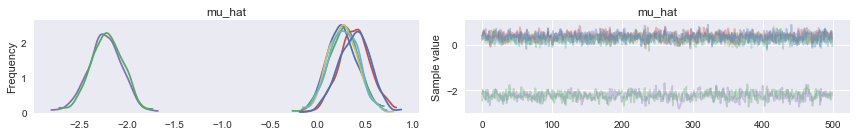

In [40]:
# data
K = 5 # number of items being ranked
J = 100 # number of raters
yreal = np.argsort(np.random.randn(K, 1), axis=0)
print(yreal.squeeze())
y = np.argsort(yreal + np.random.randn(K, J), axis=0)
print(y[:, :30])

class Ordered2D(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered2d"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0,:], x[0,:])
        out = tt.inc_subtensor(out[1:,:], tt.log(x[1:,:] - x[:-1,:]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0,:], y[0,:])
        out = tt.inc_subtensor(out[1:,:], tt.exp(y[1:,:]))
        return tt.cumsum(out, axis=0)
    
    def jacobian_det(self, y):
        return tt.sum(y[1:,:], axis=0)

# transformed data{
y_argsort = np.argsort(y, axis=0)

with pm.Model():
    mu_hat = pm.Normal('mu_hat', 0, 1, shape=K-1)
    # set first value to 0 to avoid unidentified model
    mu = tt.concatenate([[0.], mu_hat])
    #sd = pm.HalfCauchy('sigma', 1.)
    latent = pm.Normal('latent',
                       mu=mu[y_argsort],
                       sd=1., # using sd does not work yet
                       transform=Ordered2D(), 
                       shape=(K,J),
                       testval=np.repeat(np.arange(K)[:,None], J, axis=1))
                        # There are some problems with Ordered 
                        # right now, you need to give a testval
    trace = pm.sample()
pm.traceplot(trace, varnames=['mu_hat']);

print('The true ranking is: ')
print(yreal.flatten())
print('The Latent mean is: ')
latentmu = np.hstack(([0], pm.summary(trace, varnames=['mu_hat'])['mean'].values))
print(np.round(latentmu,2))
print('The estimated ranking is: ')
print(np.argsort(latentmu))